# Project2: Baseball data investigation

## Introduction 

In this project, I will investigate the [baseball dataset](http://www.seanlahman.com/baseball-archive/statistics/), which contains pitching, hitting, and fielding statistics for Major League Baseball from 1871 through 2016. The dataset is comprised of four main tables: Master, Batting, Piching and Fielding, and supplemented by many other tables, such as Teams, Managers, AwardsPlayers and so on.

The question is : **In recent years, what factors make a baseball team performance better?** I will try to find some features wich relate to team performance. The main features includes: players' average salaries, ages, heights, weights, awards of palyers and managers.


## Investigation

First of all, let's import packages wich will be used later.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

### Import Data

Then we need to import data. We choose the following six files to analyze:
* Master.csv - Player names, DOB, and biographical info
* Teams.csv - yearly stats and standings 
* Salaries.csv - player salary data
* AwardsPlayers.csv - awards won by players
* Managers.csv - managerial statistics
* AwardsManagers.csv - awards won by managers

These tables are connected with each other by teamID, playerID, and yearID.

In [2]:
# import data
columns_team = ['yearID', 'teamID', 'lgID', 'divID', 'Rank', 'G', 'W', 'L']
teams = pd.read_csv('data/Teams.csv', usecols=columns_team)

columns_player = ['playerID', 'birthYear', 'birthCountry', 'weight', 'height', 'bats', 'throws']
players = pd.read_csv('data/Master.csv', usecols=columns_player)

salaries = pd.read_csv('data/Salaries.csv')
playerAwards = pd.read_csv('data/AwardsPlayers.csv')
managers = pd.read_csv('data/Managers.csv')
managerAwards = pd.read_csv('data/AwardsManagers.csv')

Since the time span is too large, we only consider about the year after 2000 to make the results more suitable for today's situation. Then we use *merge* and *groupby* method on the dataframe of *teams*, *players* and *salaries*, which creates a large dataframe including many average features for each team per year.

In [3]:
#focus on the year after 2000 
team2k = teams[teams.yearID >= 2000]
salary2k = salaries[salaries.yearID >= 2000]

#combine palyers' information and salary
ytp = salary2k.merge(players, on='playerID', how='inner')

# group by year and team, average players
yt = ytp.groupby(['yearID', 'teamID'], as_index=False).mean()

# combine to team information
yt = yt.merge(team2k, on=['yearID', 'teamID'], how='inner')
yt.head()

,yearID,teamID,salary,birthYear,weight,height,lgID,divID,Rank,G,W,L
0,2000,ANA,1715472,1970.766667,191.966667,73.333333,AL,W,3,162,82,80
1,2000,ARI,2893851,1969.142857,190.142857,73.392857,NL,W,3,162,85,77
2,2000,ATL,2817927,1969.133333,195.466667,73.100000,NL,E,1,162,95,67
3,2000,BAL,2808532,1968.310345,194.206897,73.655172,AL,E,4,162,74,88
4,2000,BOS,2598011,1969.233333,187.633333,72.833333,AL,E,2,162,85,77


By using `info()` method, we find there is no missing values in the main dataframe. The reason is that we choose `how='inner'` when merging different dateframes.

In [4]:
yt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 498
Data columns (total 12 columns):
yearID       499 non-null int64
teamID       499 non-null object
salary       499 non-null int64
birthYear    499 non-null float64
weight       499 non-null float64
height       499 non-null float64
lgID         499 non-null object
divID        499 non-null object
Rank         499 non-null int64
G            499 non-null int64
W            499 non-null int64
L            499 non-null int64
dtypes: float64(3), int64(6), object(3)
memory usage: 50.7+ KB


### Team Performance Evaluation 

Although team rank is a good index to evaluate team performance,  we also need a continuous variable to measure team performance. From the following calculatin, we find a suitable variable: the ratio of wins, which has a strong correlation with rank.

In [5]:
#  the performance of theam - the ratio of win game
yt['WRatio'] = yt['W'] / yt['G']

In [6]:
def correlation(df, col1, col2):
    '''calculate the pearson's r and plot the correlation'''
    print("Pearson's r : %.3f" % np.corrcoef(df[col1], df[col2])[0,1])
    plt.scatter(df[col1], df[col2], alpha=0.4)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('Relationship between '+col1+' and '+col2)
    plt.show()

Pearson's r : -0.887


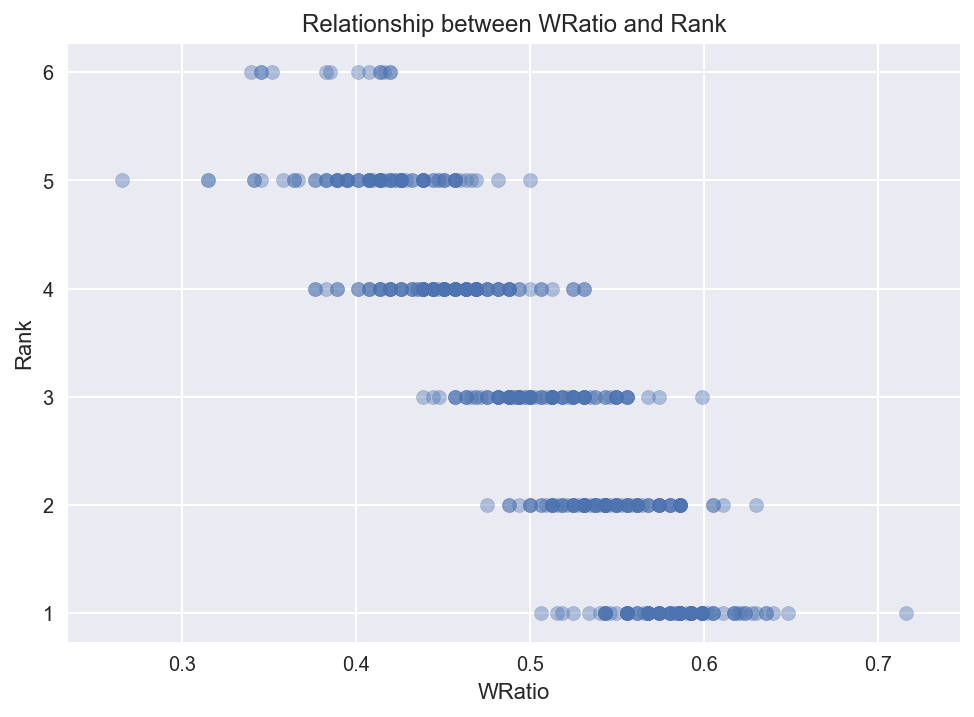

In [7]:
correlation(yt, 'WRatio', 'Rank')

### Players' salaries

First of all, we study the relationship between player's average salary and the team performance. Since salaries may fluctuate with economic environment in different years, we must standardize the salaries data first.

In [8]:
def standardize(value):
    '''convert each data point to number of 
    standard deviations away from the mean'''
    return (value - value.mean()) / value.std(ddof=0)

The plot below shows the salary distribution of teams with rank 1st and rank 6th every year. It's obvious that the Rank 1st teams' players have more chance to obtain higher salaries.

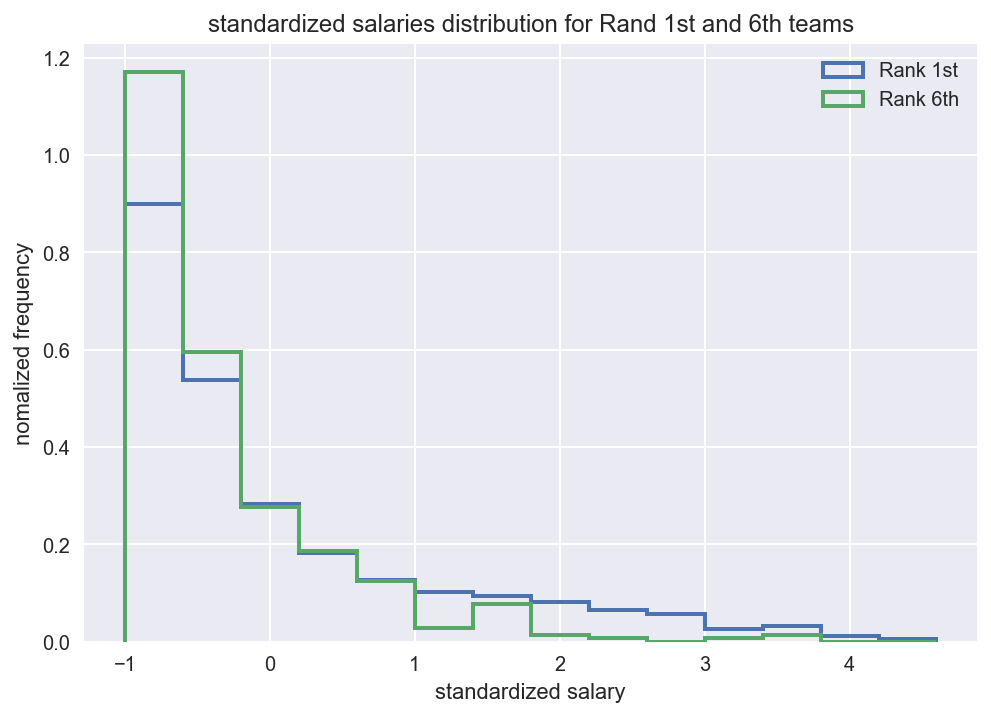

In [9]:
# get the standardized salaries for different rank teams
rank_salary = salary2k.merge(team2k[['yearID', 'teamID', 'Rank']], on=['yearID', 'teamID'], how='inner')
rank_salary['stdsalary'] = rank_salary.groupby('yearID')['salary'].apply(standardize)
high = rank_salary[rank_salary.Rank == 1]['stdsalary']
low = rank_salary[rank_salary.Rank == 6]['stdsalary']

# plot the salaries distribution for the first and last rank teams every year
bins = np.arange(-1, 5, 0.4)
plt.hist(high, histtype='step', bins=bins, linewidth=2, normed=True, label='Rank 1st')
plt.hist(low, histtype='step', bins=bins, linewidth=2, normed =True, label='Rank 6th')
plt.legend()
plt.xlabel('standardized salary')
plt.ylabel('nomalized frequency')
plt.title('standardized salaries distribution for Rand 1st and 6th teams')
plt.show()

We can also draw a box plot of salaries for teams of all ranks. There is a weak trend that the palyers in higher rank teams may have higher salaries.

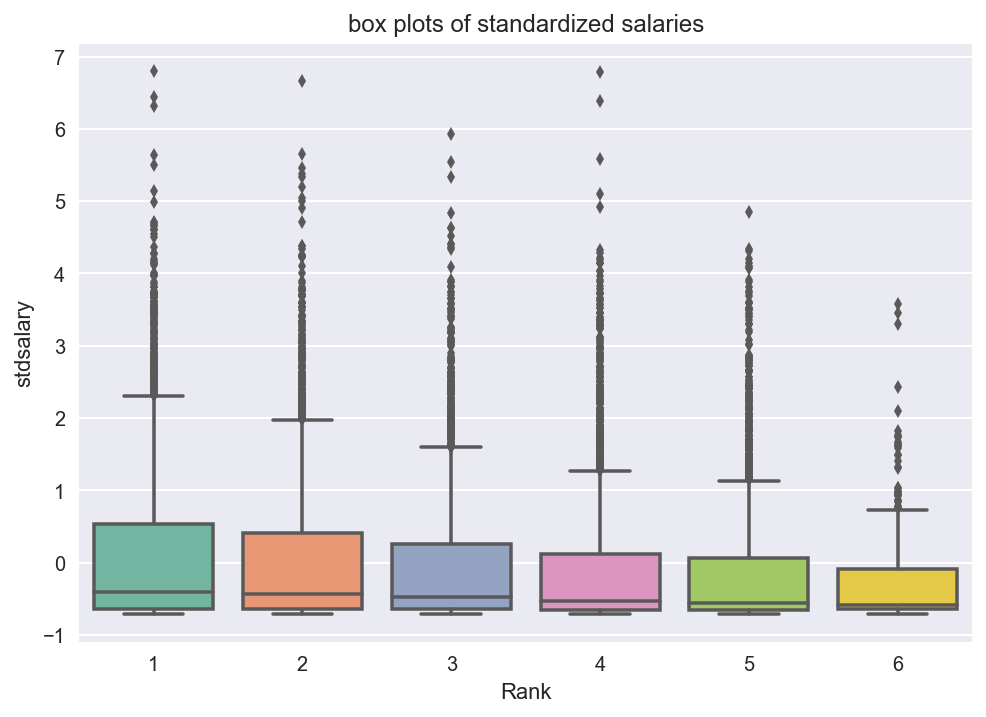

In [10]:
sns.boxplot(data=rank_salary, x='Rank', y='stdsalary', palette="Set2")
plt.title('box plots of standardized salaries')
plt.show()

To confirm this relationship, we need to calculate the correlation between team performance and average salary. A scatter plot is also shown below: the x axis stands for the standardized average salary, and y axis stands for the ratio of wins which indicates the team performance. The Pearson's r is 0.396 which shows a positive correlation between salary and team performance.

Pearson's r : 0.396


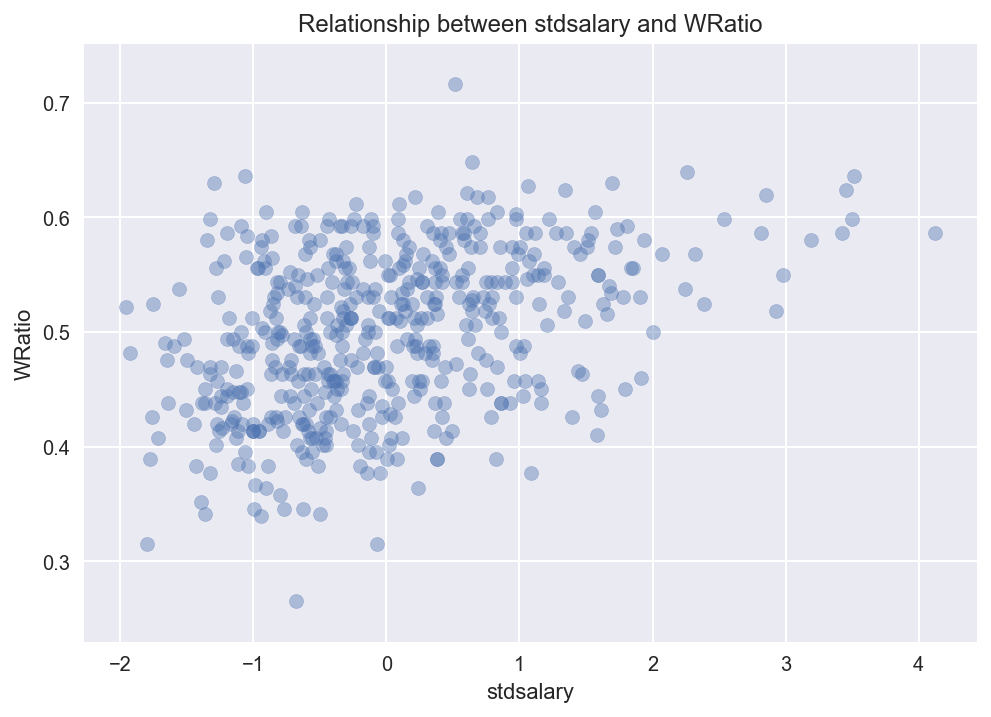

In [11]:
# standardize average salary in the same year , exclued the time influence
yt['stdsalary'] = yt.groupby('yearID')['salary'].apply(standardize)

correlation(yt, 'stdsalary', 'WRatio')

Furthermore, let's study whether this correlation exists in different leagues and divisions. There are two major baseball leagues -- American League(AL) and National League(NL), and three divisions -- West(W), Central(C), and East(E) -- for each league. There is no big difference between the American League and the National League, but when we dive into the divisions, something interesting appears. In the American League, this correlation for he East teams is very strong, while for West and Central teams the correlation is quite weak. However in the National League, the correlations for three divisions are similar.

In [12]:
for lgid in ['AL', 'NL']:
    subyt = yt[yt.lgID == lgid]
    print( '%s : %.3f' % (lgid, np.corrcoef(subyt['stdsalary'], subyt['WRatio'])[0,1]))

AL : 0.376
NL : 0.416


In [13]:
for lgid in ['AL', 'NL']:
    for divid in ['W', 'C', 'E']:
        subyt = yt[np.logical_and(yt.lgID == lgid, yt.divID == divid)]
        print('%s - %s : %.3f' % (lgid, divid, np.corrcoef(subyt['stdsalary'], subyt['WRatio'])[0,1]))
    print('')


AL - W : 0.104
AL - C : 0.228
AL - E : 0.601

NL - W : 0.444
NL - C : 0.471
NL - E : 0.372



### Players' ages

Similarly, let's calculate and plot the correlation between players' average age and team performance. We find the team with older players may have better performance. Maybe the older players have more experience which make the team more competitive.

Pearson's r : 0.303


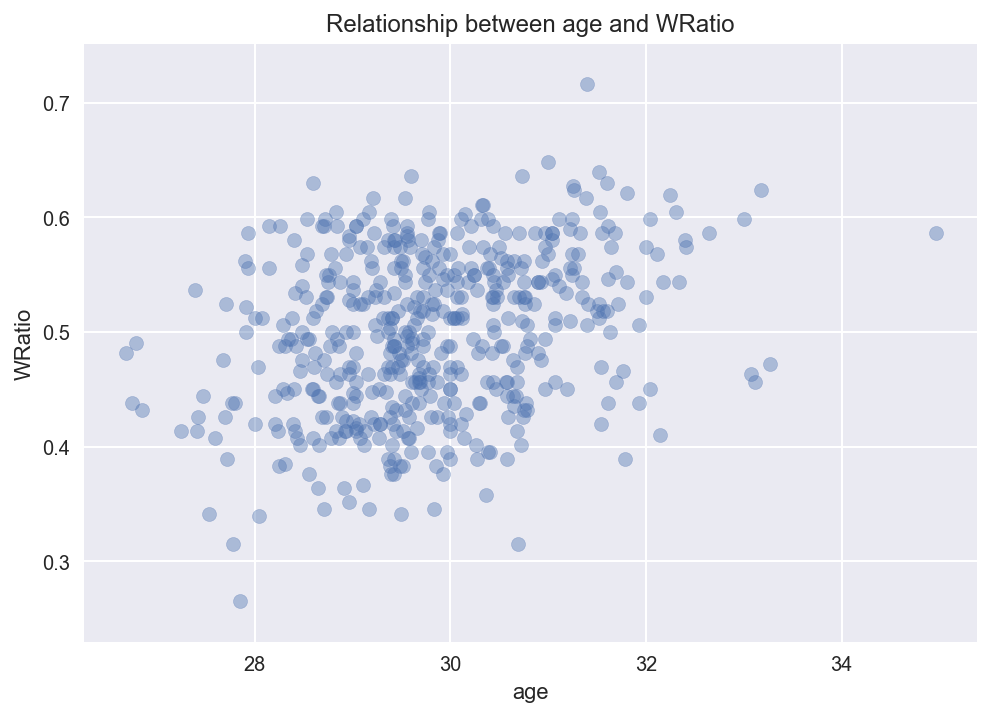

In [14]:
# average age and team performance
yt['age'] = yt['yearID'] - yt['birthYear']
correlation(yt, 'age', 'WRatio')

### Players' heights and weights

We also check the correlation between players' average height (or weight) and team performance, but there is no significant relationship.

Pearson's r : 0.035


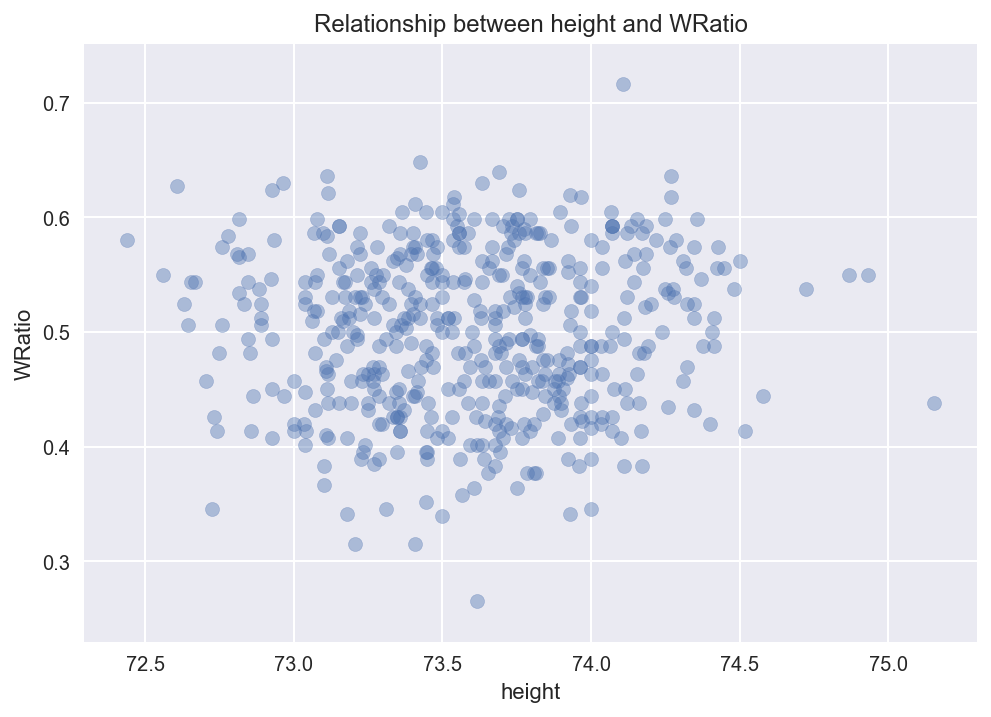

In [15]:
# height
correlation(yt, 'height', 'WRatio')

Pearson's r : 0.002


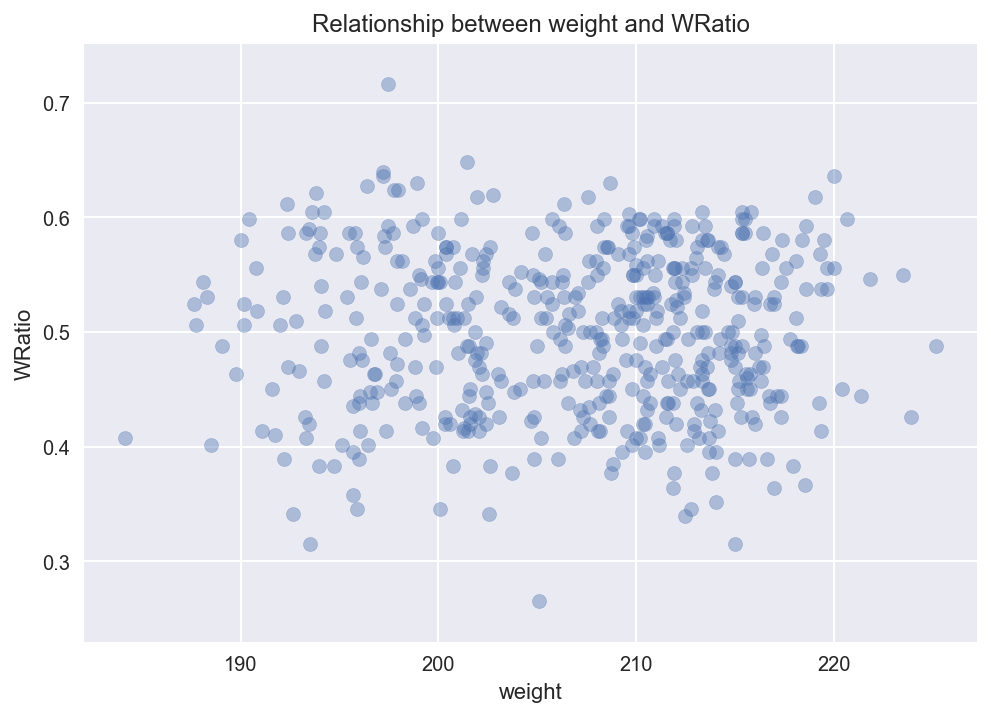

In [16]:
#weight
correlation(yt, 'weight', 'WRatio')

Let's take a deep look at players' heights in different teams. We only focus on teams belonging to American League West division in 2016, and then get the players' heights of Rank 1st and Rank 5th teams.

In [17]:
yt[(yt.yearID==2016) & (yt.divID=='W') & (yt.lgID=='AL')]

,yearID,teamID,salary,birthYear,weight,height,lgID,divID,Rank,G,W,L,WRatio,stdsalary,age
488,2016,HOU,3495118,1987.370370,209.259259,74.000000,AL,W,3,162,84,78,0.518519,-0.328000,28.629630
489,2016,LAA,5278897,1986.307692,210.576923,73.192308,AL,W,4,162,74,88,0.456790,0.962342,29.692308
493,2016,OAK,2893541,1986.200000,207.333333,72.733333,AL,W,5,162,69,93,0.425926,-0.763166,29.800000
496,2016,SEA,4845833,1985.250000,210.178571,73.785714,AL,W,2,162,86,76,0.530864,0.649074,30.750000
497,2016,TEX,6070300,1986.448276,215.517241,73.758621,AL,W,1,162,95,67,0.586420,1.534823,29.551724


In [18]:
rank1_heights = ytp[(ytp.yearID==2016) & (ytp.teamID=='TEX')]['height']
rank5_heights = ytp[(ytp.yearID==2016) & (ytp.teamID=='OAK')]['height']

A hypothesis test is made between good team 'TEX' and bad team 'OAK'. 
* The null hypothesis is that there is no difference of average heights between these two teams.
* The alternative hypothesis is that these two teams' average heights are different.

Independent T-test is applied here since we assume the heights distribution is normal and the sample size is small. From the following calculation, the p-value is 0.116. If we choose alpha level as 0.05, because p-value is larger than alpha level, we can not reject the null hypothesis. That is to say we can not find significant difference of average heights between the good and bad teams, which is consistent with the correlation result above.

In [19]:
t_stats, p_value = scipy.stats.ttest_ind(rank1_heights, rank5_heights)
print("t statistic is %.2f" % t_stats)
print("p value is %.3f" % p_value)

t statistic is 1.60
p value is 0.116


### Players' awards

We count the awards number for every player from the *playerAwards* dataframe, then merge it to team-player relation dataframe to get the average awards number for each team. Then agian we find a positive correlation between players' awards number and team performance.

It is worth mentioning that when we merege `player_awardsnum` to `ytp_relation` there will be NaN values because some players do not obtain any awards. Therefore we should deal with these missing values by filling NaNs with zeros (using `.fillna(0)`).

Pearson's r : 0.423


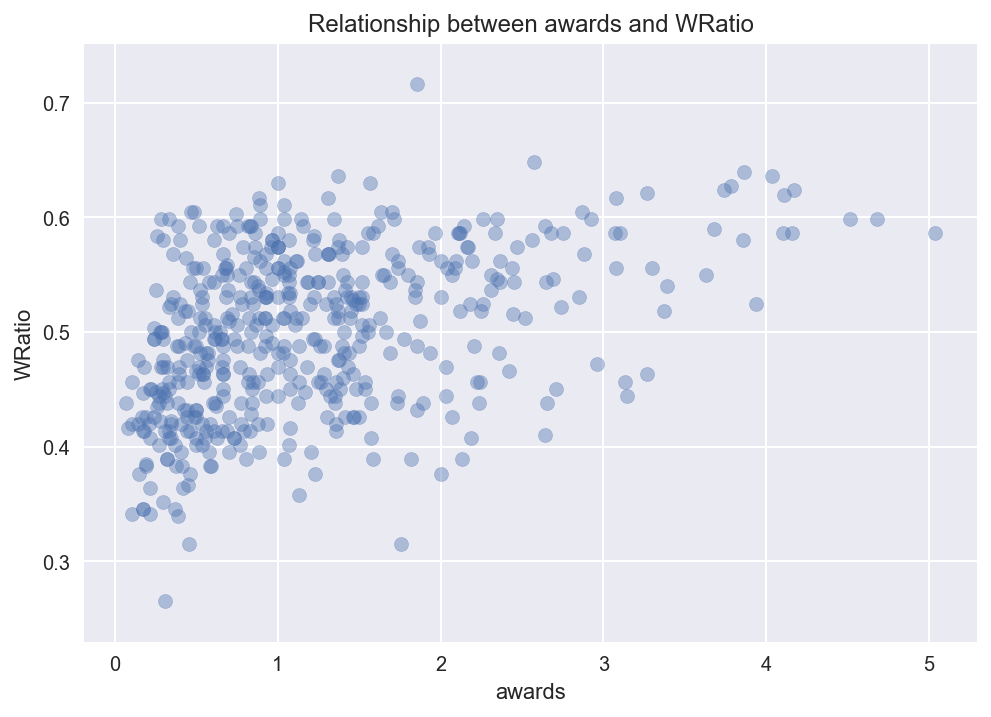

In [20]:
# sum the total awards number for every player
player_awardsnum = playerAwards.groupby('playerID', as_index=False)[['awardID']].count()
player_awardsnum.rename(columns={'awardID':'awards'}, inplace=True)

# relation between year - team - player
ytp_relation = salary2k[['yearID', 'teamID', 'playerID']]
ytp_awards = ytp_relation.merge(player_awardsnum, on='playerID', how='left').fillna(0)

#  awards for every team per year
yt_awards = ytp_awards.groupby(['yearID', 'teamID']).mean()
yt = yt.merge(yt_awards, left_on=['yearID', 'teamID'], right_index=True, how='inner' )

correlation(yt, 'awards', 'WRatio')

### Managers' awards
This time we consider the influence of managers' awards. After taking similar steps, we also find a positive correlation between managers' awards number and team performance.

Pearson's r : 0.312


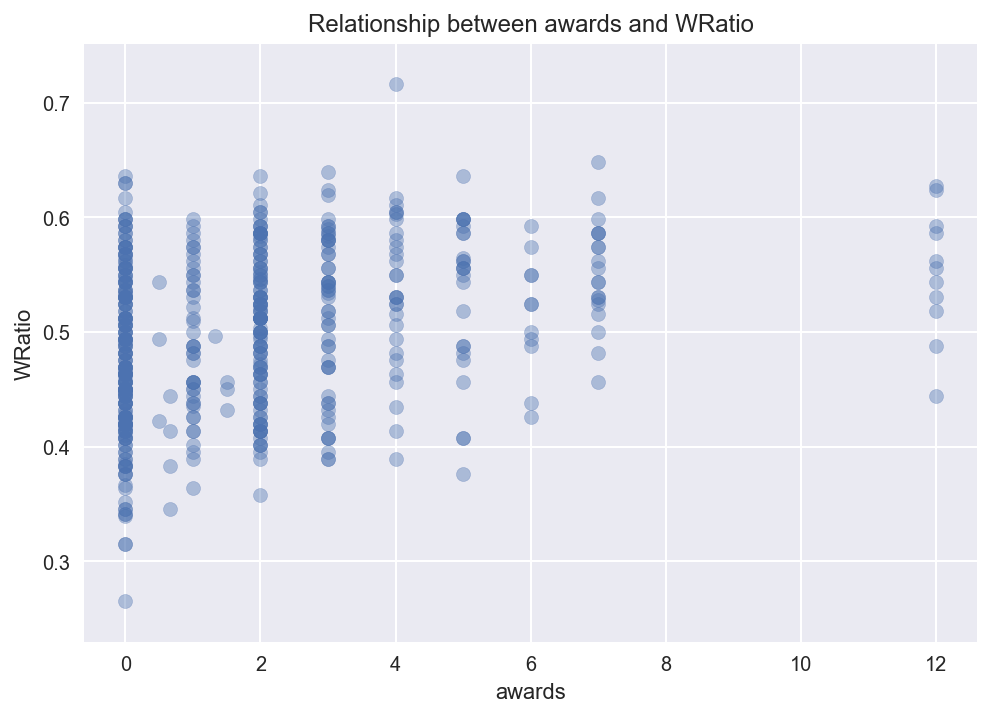

In [21]:
# consider managers' awards

manager2k = managers[managers.yearID >= 2000]

manager_awardsnum = managerAwards.groupby('playerID', as_index=False)[['awardID']].count()
manager_awardsnum.rename(columns={'awardID':'awards'}, inplace=True)
manager2k = manager2k.merge(manager_awardsnum, on='playerID', how='left').fillna(0)

yt_manager = manager2k.groupby(['yearID','teamID'], as_index=False).mean()
yt_manager['WRatio'] = yt_manager['W'] / yt_manager['G']

correlation(yt_manager, 'awards', 'WRatio')

## Conclusion

From the above investigation, we find four factors that have positive correlation with team performance since 2000. They are players' salaries, ages, awards and managers' awards. These correlations do not imply causations. Higher salaries may attract better players or inspire spirit of players and older players may have more experience. Awards gained by players and managers indicate their abilities which may improve the team performance. All these relationships with team performance are accord with our common senses.
